# 使用医疗领域数据微调 ChatGLM3

生成带有 epoch 和 timestamp 的模型文件

In [1]:
import torch
from peft import PeftModel, PeftConfig

print(torch.__config__.show(), torch.cuda.get_device_properties(0))

PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 8.9.2
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.9.2, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUS

In [2]:
# 定义全局变量和参数
model_name_or_path = 'THUDM/chatglm3-6b'  # 模型ID或本地路径
train_data_path = 'data/conversations_data.csv'    # 训练数据路径
eval_data_path = None                     # 验证数据路径，如果没有则设置为None
per_device_eval_batch_size: 16
evaluation_strategy: "steps"
eval_steps: 500
seed = 8                                 # 随机种子
max_input_length = 512                    # 输入的最大长度
max_output_length = 1536                  # 输出的最大长度
lora_rank = 16                             # LoRA秩
lora_alpha = 32                           # LoRA alpha值
lora_dropout = 0.05                       # LoRA Dropout率
prompt_text = ''                          # 所有数据前的指令文本
peft_model_path = "models/THUDM/chatglm3-6b-epoch10"

## 数据处理

In [3]:
from datasets import load_dataset

# dataset = load_dataset("csv", data_files=train_data_path)
# print(dataset)

# 假设你的JSON文件位于当前目录下的"data"文件夹中
file_path = "data/GenMedGLM-8k.json"

# 使用data_files参数指定JSON文件路径
dataset = load_dataset("json", data_files=file_path)

print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output'],
        num_rows: 7965
    })
})


In [4]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [5]:
show_random_elements(dataset["train"], num_examples=5)

,input,instruction,output
0,知疗法的步骤包括：\n\n- 了解病人的情况，建立治疗关系，帮助病人认识到自己的需要和价值观。\n- 帮助病人识别和检验自动想法，以及功能失调性假设。\n- 制定行为计划和作业，鼓励病人积极参与治疗过程。\n- 采用认知行为疗法，帮助病人改变思维方式和信息加工过程。\n- 进行观察、记录和评估，以便病人能够进一步检验自己的治疗效果。\n\n对于你的要求，我可以给出以下,如果您是医生，请根据患者的描述回答医学问题。,\n\n- 问题：你继续工作，是否有助于减轻你的焦虑？\n-
1,在医学研究中，如何确定样本的大小和采样方法？\n\n,如果您是医生，请根据患者的描述回答医学问题。,确定样本的大小和采样方法对于医学研究中的数据收集和分析至关重要。\n\n一般来说，样本的大小应该根据研究目的、研究对象和可用资源等因素来确定。在确定样本大小时，需要考虑样本代表性、可靠性和有效性等方面。\n\n采样方法也需要考虑的因素，例如采样方式、采样区域、采样频率和采样方式等。采样方法的选择应该根据研究对象的特点、研究目的和可用资源等因素进行考虑。\n\n例如，在研究某个疾病的发病率时，可以采用随机抽样的方法，即让研究对象随机选择某个样本，然后进行样本的抽样和收集数据。而在研究某个疾病的预防时，可以采用重点采样的方法，即选择研究对象中病情较为严重或存在高风险的进行重点采样，以获得更可靠的数据。\n\n总之，在医学研究中，确定样本的大小和采样方法是非常重要的，需要根据研究目的、研究对象和可用资源等因素进行综合考虑和选择。
2,如何检测新冠病毒感染？\n\n,如果您是医生，请根据患者的描述回答医学问题。,新冠病毒感染可以通过多种方法进行检测，包括核酸检测、抗原检测和抗体检测等。\n\n1. 核酸检测：是目前最常用的检测方法之一，可以通过取患者鼻咽部或口腔样本，进行PCR扩增检测，来判断患者是否感染了新冠病毒。核酸检测的准确性较高，但需要时间较长，通常需要2-4天。\n\n2. 抗原检测：是通过检测患者血清中是否存在新冠病毒的抗原来确定是否感染了新冠病毒。这种检测方法通常需要进行免疫学反应，可以使用单克隆抗体或酶联免疫吸附试验等进行检测。\n\n3. 抗体检测：是通过检测患者血清中是否存在新冠病毒的抗体来确定是否感染了新冠病毒。这种检测方法通常需要进行免疫学反应，可以使用单克隆抗体或酶联吸附试验等进行检测。\n\n除了上述方法外，还有一些其他检测方法，如荧光密螺旋体抗体吸附试验(FTA-ABS)、抗新冠病毒微量血疑试验(MHA-TP)等，但通常需要更专业的技术设备和实验室来进行。\n\n需要注意的是，不同的检测方法可能会有一些差异，具体的检测方法和结果也需要根据具体情况来确定。同时，如果感染了新冠病毒，建议及时进行核酸检测或抗原检测，并遵循医生的建议进行治疗和隔离。
3,在偏头痛发作期间，医生通常会给患者使用什么药物来缓解症状？\n\n,如果您是医生，请根据患者的描述回答医学问题。,在偏头痛发作期间，医生通常会给患者使用一些药物来缓解症状，如口服的马来酸麦角新碱和肌内注射的雌激素类药物。\n\n马来酸麦角新碱是一种刺激性药物，可以刺激子宫收缩，从而缓解偏头痛的症状。另外，雌激素类药物也可以刺激子宫收缩，从而缓解偏头痛的症状。\n\n需要注意的是，使用这些药物时需要遵循医生的建议，因为这些药物可能会引起一些副作用，如头晕、恶心、呕吐等。因此，在使用这些药物之前，最好先咨询医生的意见，以便更好地掌握用药方法和剂量。
4,什么是膀胱尿道镜取石或碎石？\n\n,如果您是医生，请根据患者的描述回答医学问题。,膀胱尿道镜是一种医学检查工具，通常由一根细棒状的镜头和一支光源组成。它可以用来观察和操作膀胱和尿道内部的情况，包括取石和碎石。膀胱尿道镜可以帮助医生在患者身上进行精细的手术操作，同时还可以诊断和治疗一些膀胱和尿道疾病。


In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=True)

Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.


In [7]:
# tokenize_func 函数
def tokenize_func(example, tokenizer, ignore_label_id=-100):
    # 构建问题文本
    question = example['instruction'] + example['input']
    if example.get('input', None) and example['input'].strip():
        question += f'\n{example["input"]}'

    # 构建答案文本
    answer = example['output']

    # 对问题和答案文本进行tokenize处理
    q_ids = tokenizer.encode(text=question, add_special_tokens=False)
    a_ids = tokenizer.encode(text=answer, add_special_tokens=False)

    # 如果tokenize后的长度超过最大长度限制，则进行截断
    if len(q_ids) > max_input_length - 2:  # 保留空间给gmask和bos标记
        q_ids = q_ids[:max_input_length - 2]
    if len(a_ids) > max_output_length - 1:  # 保留空间给eos标记
        a_ids = a_ids[:max_output_length - 1]

    # 构建模型的输入格式
    input_ids = tokenizer.build_inputs_with_special_tokens(q_ids, a_ids)
    question_length = len(q_ids) + 2  # 加上gmask和bos标记

    # 构建标签，对于问题部分的输入使用ignore_label_id进行填充
    labels = [ignore_label_id] * question_length + input_ids[question_length:]

    return {'input_ids': input_ids, 'labels': labels}


In [8]:
column_names = dataset['train'].column_names
tokenized_dataset = dataset['train'].map(
    lambda example: tokenize_func(example, tokenizer),
    batched=False, 
    remove_columns=column_names
)

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

In [9]:
# 初始化一个计数器
total_tokens = 0

# 遍历tokenized_dataset中的所有样本
for example in tokenized_dataset:
    # 累加每个样本的input_ids长度
    total_tokens += len(example['input_ids'])

print(f"整个数据集的总token数量是: {total_tokens}")

整个数据集的总token数量是: 1751403


/home/solidus/anaconda3/envs/llm_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/solidus/anaconda3/envs/llm_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/solidus/anaconda3/envs/llm_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/solidus/anaconda3/envs/llm_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/solidus/anaconda3/envs/llm_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

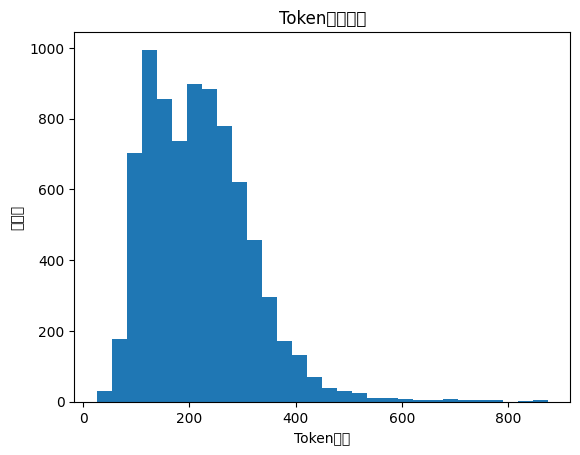

In [10]:
# 导入matplotlib进行可视化
import matplotlib.pyplot as plt

# 计算每个样本的token数量
token_lengths = [len(example['input_ids']) for example in tokenized_dataset]

# 绘制直方图
plt.hist(token_lengths, bins=30)
plt.title('Token数量分布')
plt.xlabel('Token数量')
plt.ylabel('样本数')
plt.show()

In [11]:
tokenized_dataset = tokenized_dataset.shuffle(seed=seed)
tokenized_dataset = tokenized_dataset.flatten_indices()

Flattening the indices:   0%|          | 0/7965 [00:00<?, ? examples/s]

In [12]:
import torch
from typing import List, Dict, Optional

# DataCollatorForChatGLM 类
class DataCollatorForChatGLM:
    """
    用于处理批量数据的DataCollator，尤其是在使用 ChatGLM 模型时。

    该类负责将多个数据样本（tokenized input）合并为一个批量，并在必要时进行填充(padding)。

    属性:
    pad_token_id (int): 用于填充(padding)的token ID。
    max_length (int): 单个批量数据的最大长度限制。
    ignore_label_id (int): 在标签中用于填充的ID。
    """

    def __init__(self, pad_token_id: int, max_length: int = 2048, ignore_label_id: int = -100):
        """
        初始化DataCollator。

        参数:
        pad_token_id (int): 用于填充(padding)的token ID。
        max_length (int): 单个批量数据的最大长度限制。
        ignore_label_id (int): 在标签中用于填充的ID，默认为-100。
        """
        self.pad_token_id = pad_token_id
        self.ignore_label_id = ignore_label_id
        self.max_length = max_length

    def __call__(self, batch_data: List[Dict[str, List]]) -> Dict[str, torch.Tensor]:
        """
        处理批量数据。

        参数:
        batch_data (List[Dict[str, List]]): 包含多个样本的字典列表。

        返回:
        Dict[str, torch.Tensor]: 包含处理后的批量数据的字典。
        """
        # 计算批量中每个样本的长度
        len_list = [len(d['input_ids']) for d in batch_data]
        batch_max_len = max(len_list)  # 找到最长的样本长度

        input_ids, labels = [], []
        for len_of_d, d in sorted(zip(len_list, batch_data), key=lambda x: -x[0]):
            pad_len = batch_max_len - len_of_d  # 计算需要填充的长度
            # 添加填充，并确保数据长度不超过最大长度限制
            ids = d['input_ids'] + [self.pad_token_id] * pad_len
            label = d['labels'] + [self.ignore_label_id] * pad_len
            if batch_max_len > self.max_length:
                ids = ids[:self.max_length]
                label = label[:self.max_length]
            input_ids.append(torch.LongTensor(ids))
            labels.append(torch.LongTensor(label))

        # 将处理后的数据堆叠成一个tensor
        input_ids = torch.stack(input_ids)
        labels = torch.stack(labels)

        return {'input_ids': input_ids, 'labels': labels}


In [13]:
# 准备数据整理器
data_collator = DataCollatorForChatGLM(pad_token_id=tokenizer.pad_token_id)

## 加载模型

In [14]:
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
_compute_dtype_map = {
    'fp32': torch.float32,
    'fp16': torch.float16,
    'bf16': torch.bfloat16
}

# QLoRA 量化配置
q_config = BitsAndBytesConfig(load_in_4bit=True,
                              bnb_4bit_quant_type='nf4',
                              bnb_4bit_use_double_quant=True,
                              bnb_4bit_compute_dtype=_compute_dtype_map['bf16'])
# 加载量化后模型
base_model = AutoModel.from_pretrained(model_name_or_path,
                                  quantization_config=q_config,
                                  device_map='auto',
                                  trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [15]:
# 加载量化后模型
config = PeftConfig.from_pretrained(peft_model_path)
model = PeftModel.from_pretrained(base_model, peft_model_path)

In [16]:
from peft import TaskType, LoraConfig, get_peft_model, prepare_model_for_kbit_training
from peft.utils import TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING

kbit_model = prepare_model_for_kbit_training(model)
target_modules = TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING['chatglm']

In [17]:
target_modules

['query_key_value']

In [18]:
lora_config = LoraConfig(
    target_modules=target_modules,
    r=lora_rank,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias='none',
    inference_mode=False,
    task_type=TaskType.CAUSAL_LM
)

In [19]:
qlora_model = get_peft_model(kbit_model, lora_config)
qlora_model.print_trainable_parameters()

trainable params: 3,899,392 || all params: 6,247,483,392 || trainable%: 0.06241540401681151


### QLoRA 微调模型

In [20]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

train_epochs = 1
# output_dir = f"models/{model_name_or_path}-epoch{train_epochs}-{timestamp}"
output_dir = f"models/{model_name_or_path}-epoch{train_epochs}-medical"

In [24]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_dir,                            # 输出目录
    per_device_train_batch_size=1,                     # 每个设备的训练批量大小
    gradient_accumulation_steps=1,                     # 梯度累积步数
    learning_rate=1e-3,                                # 学习率
    num_train_epochs=train_epochs,                     # 训练轮数
    lr_scheduler_type="linear",                        # 学习率调度器类型
    warmup_ratio=0.1,                                  # 预热比例
    logging_steps=100,                                 # 日志记录步数
    save_strategy="steps",                             # 模型保存策略
    save_steps=500,                                    # 模型保存步数
    optim="adamw_torch",                               # 优化器类型
    fp16=True,                                        # 是否使用混合精度训练
)


In [25]:
trainer = Trainer(
        model=qlora_model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator
    )

In [27]:
# trainer.train()

Step,Training Loss
100,1.801100
200,1.689900
300,1.768000
400,1.787600
500,1.690600
600,1.790800
700,1.688800
800,1.824200
900,1.882400
1000,1.828300


In [ ]:
trainer.train(resume_from_checkpoint=True)

In [ ]:
trainer.model.save_pretrained(output_dir)